In [1]:
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter

In [6]:
#the function that use boxplot to remove the outliers
def boxplot_outliers(data):
    # finding the 1st quartile
    q1 = np.quantile(data, 0.25)
    
    # finding the 3rd quartile
    q3 = np.quantile(data, 0.75)
    
    # finding the iqr region
    iqr = q3-q1
    
    # finding upper and lower whiskers
    upper_bound = q3+(15*iqr)
    lower_bound = q1-(15*iqr)
    print(lower_bound,upper_bound)

    removed = [x for x in data if lower_bound < x < upper_bound]

    return removed

In [8]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Read video with OpenCV.
cap=cv2.VideoCapture('../UPDRS_video/leg_agility/WholeBody2_right.mp4')

# Get video info
RES=(round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fps = round(cap.get(cv2.CAP_PROP_FPS))

#create video writer to write detected_video
output_video = "result_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(output_video, fourcc, fps, RES)

In [9]:
#Create a mediapipe pose instance to detect the joints in each frame in the video
#Set static_image_mode to "True" can get more accurate results (but run more slowly)
pose = mp_pose.Pose(static_image_mode=True,min_detection_confidence=0.4)

right_heel = [] #for calculating the height of foot lift (right foot)
ankle_dis = [] # for calculating the step length
right_foot_index = [] #for calculating the number of stomping (right foot)
right_shoulder = [] #for calculating the time of arising from chair
left_shoulder = []
lost_frame = [] #record the frame index that has no detection
img_list = []
frame_count = 0
while(cap.isOpened()):
    ret, frame = cap.read()

    if ret == True:

        # Convert the BGR image to RGB and process it with MediaPipe Pose.
        results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        annotated_image = frame.copy()

        if results.pose_landmarks != None:
            mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            right_heel.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HEEL].y)
            right_foot_index.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y)

            right_shoulder.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y)
            left_shoulder.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y)

            right_ankle_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x
            left_ankle_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].x
            ankle_dis.append(abs(right_ankle_x-left_ankle_x))
            
            
        else:
            lost_frame.append(frame_count)

        img_list.append(annotated_image)
        frame_count += 1


    else:
        break

cap.release()

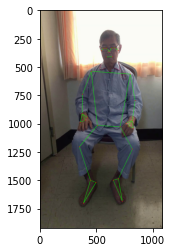

In [10]:
#show the detected image
result_img = img_list[0].copy()
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))

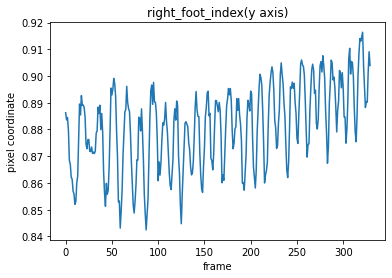

In [11]:
#plot the result
plt.title("right_foot_index(y axis)")
plt.xlabel("frame")
plt.ylabel("pixel coordinate")
plt.plot(right_foot_index)

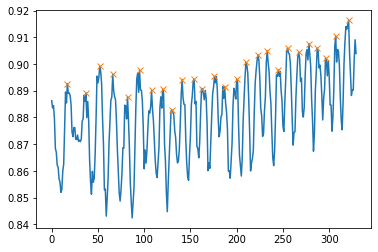

In [12]:
#Calculate the leg agility
copy = right_foot_index.copy()
peaks, _ = signal.find_peaks(copy,height=0.86,prominence=0.01)

plt.plot(copy)
plt.plot(peaks,np.array(copy)[peaks],"x")

#calculcate stomp action time
action_time_list = []
action_time_list.append(peaks[0])
for time in np.diff(peaks):
    action_time_list.append(time)

In [ ]:
#calculate the gait
smooth = savgol_filter(ankle_dis,11,3) #use Savitzky–Golay filter to smooth the data

peaks, _ = signal.find_peaks(smooth,height=0.08,prominence=0.03)

plt.title("ankle distance")
plt.xlabel("frame")
plt.ylabel("pixel coordinate")

plt.plot(smooth)
plt.plot(peaks,np.array(smooth)[peaks],"x")


In [ ]:
#Calculate the time of arising from chair
copy = savgol_filter(right_shoulder,31,3)

mid = (min(right_shoulder) + max(right_shoulder))/2
pro = (max(right_shoulder) - mid)

peaks, _ = signal.find_peaks(copy,height=mid,prominence=pro)
valley, _ = signal.find_peaks(np.array(copy)*-1,height=mid*-1)

start_frame = peaks[0]
end_frame = valley[0]

plt.title("right_shoulder")
plt.xlabel("frame")
plt.ylabel("pixel coordinate")

plt.plot(copy)
plt.plot(peaks,np.array(copy)[peaks],"x")
plt.plot(valley,np.array(copy)[valley],"o")
#plt.savefig("../UPDRS_result/arise/arise_wave.png")

In [13]:
#write result to video (leg agility)
action_count = 0
action_time = 0
has_result = 0
for i in range(len(img_list)):
    if len(peaks) > action_count and has_result == peaks[action_count]:
        action_time = action_time_list[action_count]
        action_count += 1
    if i not in lost_frame:
        has_result += 1

    cv2.putText(img_list[i],f'action_count:{action_count}',(10, 70), cv2.FONT_HERSHEY_SIMPLEX,1.5, (0, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(img_list[i],f'action_time:{action_time/fps:.2f}s',(10, 120), cv2.FONT_HERSHEY_SIMPLEX,1.5, (0, 0, 0), 3, cv2.LINE_AA)
    out.write(img_list[i])

out.release()

In [ ]:
#write result to video (gait)
step = 0
step_length = 0
has_result = 0
for i in range(len(img_list)):
    if len(peaks) > step and has_result == peaks[step]:
        step_length = ankle_dis[peaks[step]]
        step += 1
    if i not in lost_frame:
        has_result += 1

    cv2.putText(img_list[i],f'step:{step}',(10, 70), cv2.FONT_HERSHEY_SIMPLEX,1.5, (255, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(img_list[i],f'step_length:{step_length:.2f}',(10, 120), cv2.FONT_HERSHEY_SIMPLEX,1.5, (255, 0, 0), 3, cv2.LINE_AA)
    out.write(img_list[i])

out.release()

In [ ]:
#write result to video (arise from chair)
action_time = 0
has_result = 0
time_count = 0
state = "sit"
for i in range(len(img_list)):
    if i not in lost_frame:
        if has_result == start_frame:
            state = "arise"
        elif has_result == end_frame:
            state = "stand"
        has_result += 1
    if state == "arise":
        time_count+=1

    cv2.putText(img_list[i],f'state:{state}',(10, 70), cv2.FONT_HERSHEY_SIMPLEX,1.5, (255, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(img_list[i],f'action_time:{time_count/fps:.2f}s',(10, 120), cv2.FONT_HERSHEY_SIMPLEX,1.5, (255, 0, 0), 3, cv2.LINE_AA)
    out.write(img_list[i])

out.release()